In [1]:
%pip install fastai pandas matplotlib --quiet



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import pandas as pd
from pathlib import Path

# Path to your JSON label file
json_path = Path('Train/labels_v1.2.json')

# Read the JSON file
with open(json_path) as f:
    data = json.load(f)

rows = []
for item in data:
    filename = item['filename']
    objects = item['Labels']['objects']
    label = 'normal'
    for obj in objects:
        conditions = obj.get('conditions', {})
        if any(v != 'No issues' for v in conditions.values()):
            label = 'damaged'
            break
    rows.append({'filename': filename, 'label': label})

df = pd.DataFrame(rows)
df.to_csv('labels_for_fastai.csv', index=False)
print('Saved labels_for_fastai.csv with', len(df), 'entries.')


Saved labels_for_fastai.csv with 1600 entries.


In [3]:
from fastai.vision.all import *
import pandas as pd
from pathlib import Path

# Load the CSV
df = pd.read_csv('labels_for_fastai.csv')
print(df.head())

# Path to images
img_path = Path('Train/Images')

# Check if images exist
missing = [f for f in df['filename'] if not (img_path/f).exists()]
print(f'Missing images: {len(missing)}')
if missing:
    print('Example missing:', missing[:5])


      filename    label
0   100228.JPG  damaged
1  100228h.JPG  damaged
2  100228v.JPG  damaged
3  100228d.JPG  damaged
4   130064.jpg  damaged
Missing images: 0


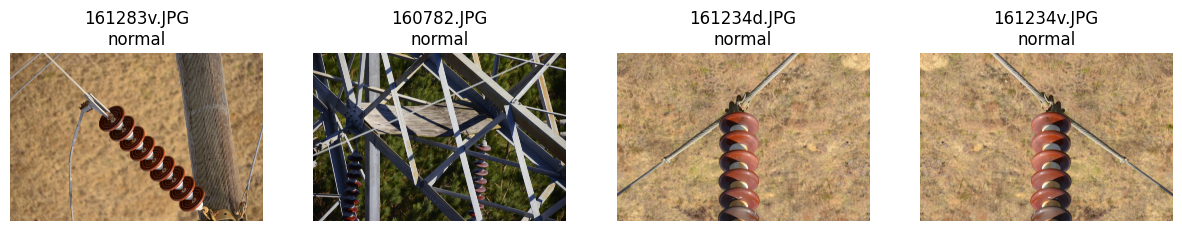

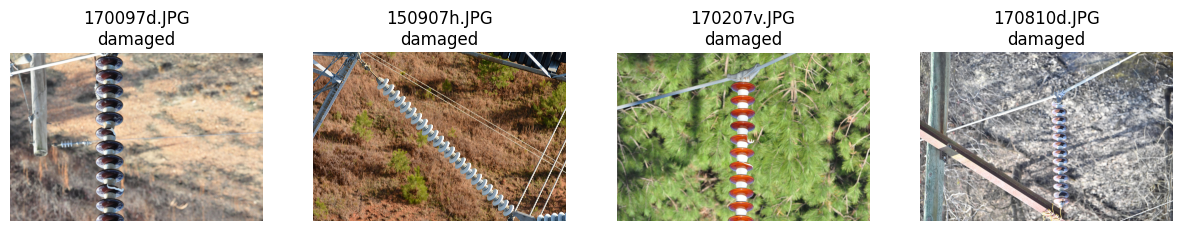

In [4]:
import matplotlib.pyplot as plt

def show_samples(label, n=4):
    samples = df[df['label'] == label].sample(n)
    fig, axs = plt.subplots(1, n, figsize=(15, 4))
    for ax, (_, row) in zip(axs, samples.iterrows()):
        img = PILImage.create(img_path/row['filename'])
        ax.imshow(img)
        ax.set_title(f'{row["filename"]}\n{label}')
        ax.axis('off')
    plt.show()

show_samples('normal')
show_samples('damaged')


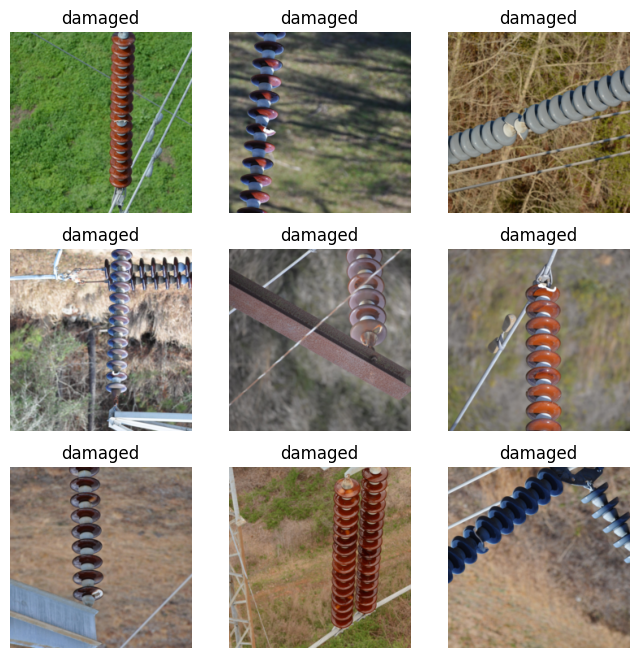

In [5]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('filename', pref=img_path),
    get_y=ColReader('label'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224)
)

dls = dblock.dataloaders(df)
dls.show_batch(max_n=9, figsize=(8,8))


SuggestedLRs(valley=0.005248074419796467)

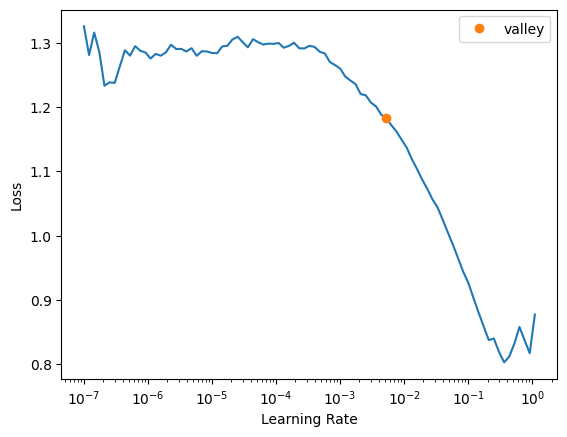

In [6]:
# Create the learner
learn = vision_learner(dls, resnet34, metrics=accuracy)

# Find a good learning rate
learn.lr_find()


In [7]:
# Train the model
learn.fine_tune(5, base_lr=52e-4)  # Train for 5 epochs


epoch,train_loss,valid_loss,accuracy,time
0,1.053287,0.505595,0.775000,00:51


epoch,train_loss,valid_loss,accuracy,time
0,0.552145,0.408681,0.837500,00:52
1,0.424752,0.164657,0.968750,00:52
2,0.294903,0.068176,0.990625,00:51
3,0.202543,0.031350,0.993750,00:51
4,0.142836,0.027894,0.993750,00:51


Classification Report:
               precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       318
     Damaged       0.00      0.00      0.00         2

    accuracy                           0.99       320
   macro avg       0.50      0.50      0.50       320
weighted avg       0.99      0.99      0.99       320



/home/duke/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/duke/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/duke/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


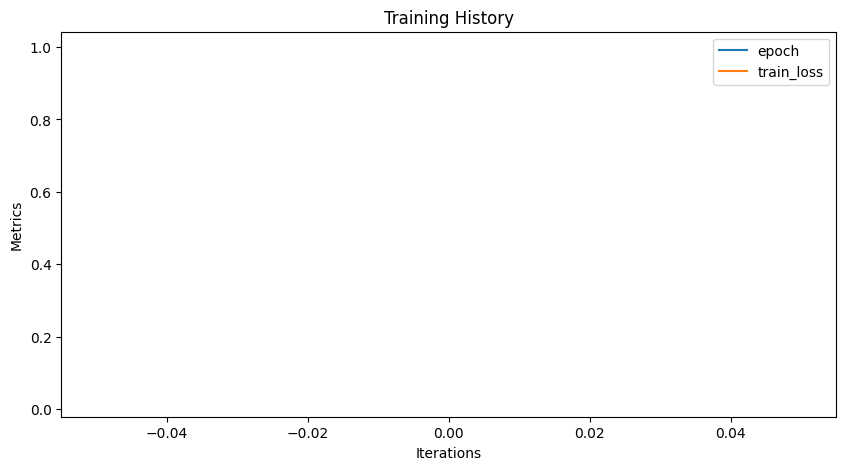

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

<Figure size 1000x800 with 0 Axes>

In [9]:
# Calculate and display detailed metrics
from sklearn.metrics import classification_report, precision_recall_curve
import seaborn as sns

# Get predictions
preds, targets = learn.get_preds()
pred_labels = preds.argmax(dim=1)

# Create classification report
report = classification_report(targets, pred_labels, target_names=['Normal', 'Damaged'])
print("Classification Report:\n", report)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(learn.recorder.values)
plt.legend(learn.recorder.metric_names)
plt.title('Training History')
plt.xlabel('Iterations')
plt.ylabel('Metrics')
plt.show()

# Plot confusion matrix with percentages
interp = ClassificationInterpretation.from_learner(learn)
cm = interp.confusion_matrix()
plt.figure(figsize=(10, 8))
sns.heatmap(cm.numpy()/cm.sum()*100, annot=True, fmt='.1f', cmap='Blues')
plt.title('Confusion Matrix (%)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# Get the interpretation object
interp = ClassificationInterpretation.from_learner(learn)

# Plot confusion matrix
interp.plot_confusion_matrix(figsize=(8,8))


In [ ]:
# Show top losses
interp.plot_top_losses(9, figsize=(15,11))


In [ ]:
learn.export('insulator_classifier.pkl')
print('Model saved as insulator_classifier.pkl')
